<a href="https://colab.research.google.com/github/JohanRensfeldt/Application-Oriented-Deep-Learning-in-Physics/blob/main/Kopia_av_Copy_of_cnn_its_lab_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DNA motif discovery using CNN

In this lab, we will use convolutional neural networks (CNN) to detect certain motifs (DNA fragments following specific pattern) in plant DNA sequences downloaded from GenBank.

### Data
The first step is to go to [GenBank](https://https.ncbi.nlm.nih.gov/genbank/) database [FTP service](https://ftp.ncbi.nih.gov/genbank/) and download some data. Whenever researchers sequence DNA coming from an organism and publish their finding, the DNA sequences are deposited in GeneBank. In their FTP service, one can see a number of `gb***N.seq.gz` files where `***` is an abbreviation for a group of organisms DNA sequences come from, e.g. `bct` for bacteria or `pln` for plants and `N` is a sequence number assigned in a consecutive manner to deposited files. We have downloaded one of such files `gbpln132.seq.gz` and converted it to an easier-to-read format called [FASTA](https://en.wikipedia.org/wiki/FASTA). If you are curious and would like to prepare your own dataset, we used the following `BioPython` file IO routines to convert from GenBank format to FASTA:
```
from Bio import SeqIO
SeqIO.convert("gbpln132.seq", "genbank", "gbpln132.fasta", "fasta")
```

### DNA metabarcoding and amplicon sequencing

Now, let me introduce you to a real research problem. Say, we go to a grocery store and buy a mix of spices. There are some spices listed on a label, but how can we make sure that there actually is basil or onion in the mix? One of the ways to figure this out is to extract DNA from these dried powdered spices and use it to single out species composition. This part can be somewhat tricky itself as it is not trivial to extract DNA from such mix that possibly also contains some chemicals that may damage the DNA or make extraction very inefficient. Say, however, we have solved this issue, now we can go two ways: 
* sequence all DNA fragments and hope they will say something about the species composition. The risk is, however, that we won't have enough material that is specific to a given species and thus, we end up below the detection level.
* try to PCR-amplify (make many copies) of some 'magic' sequence fragments that, we know, are very specific/characteristic to different species. This is called **amplicon sequencing**. 

In this lab, we will go for the second approach. How does it work? Well, first, we need to have some barcodes (special DNA sequence fragments) that are suitable for species identification.

### Properties a DNA barcode

Back to our jar of spices -- we know that, at least in theory, the plants that are on the label should be there, but what else can this jar contain? It can be anything! In fact, any imaginable plant species in the world! So, what we need is a DNA fragment that we know all plants have, so that we can amplify this sequence fragment and we do not risk missing out something. At the same time this should be a **barcode**, i.e. a sequence that is different between all plant species so that we can uniquely identify its source. Sounds like a contradiction? What about a sequence that looks something like this:  

```
cccccccccccccccccUUUUUUUUUUUUUUUUUUCCCCCCCCCCCCCC
```
where `cccccccccc` and `CCCCCCCCCCC` are common for all plants and `UUUUUUUUU` fragment inside is unique for every plant species. What we can do now is to design molecular probes that will fish out `UUUUUUUU` based on it being flanked by `cccc` and `CCCCCC`. 

### ITS1 and ITS2

Quite fortunately for us, such barcodes exist and the two most commonly used types of sequences used for plan identification are called ITS1 and ITS2. They look exactly as we want them to look. Well, with a caveat that sometimes the `UUUUUU` part is similar between some plants but the ITS-es are good enough for many applications. You can read more about ITS-es [here](https://en.wikipedia.org/wiki/Internal_transcribed_spacer).

### Our task
In this lab, we will see whether we can train CNN to be able to detect short sequence fragments (k-mers) coming from ITS and non-ITS sequences. If we succeed, we will have made the first step towards species identification.

In [ ]:
!pip install biopython
import os
from Bio import SeqIO
import numpy as np
import pandas as pd

# Download example GenBank data
!wget https://www.dropbox.com/s/zjze886uove04s1/gbpln132.fasta

# Read fasta file with sequences
input_file = open('gbpln132.fasta', 'r')

k_mer_size = 150 # we set our k-mer size here
frac_to_take = 0.01 # fraction of sequences to work with due to memeory limits of Colab

seq_lengths = []
its_seq = []
non_its_seq = []

# Below we filter out sequences shorter than k-mer size and the ones 
# that contain Ns (we can change it later). We also populate its1, its2 and non-its
# arrays. 
for sequence in SeqIO.parse(input_file, "fasta") :
  seq_lengths.append(len(sequence.seq))
  if len(sequence.seq) >= k_mer_size and 'NN' not in sequence.seq:
    if 'ITS1' in sequence.description:
      its_seq.append(sequence.seq)
    elif 'ITS2' in sequence.description:
      its_seq.append(sequence.seq)
  if 'ITS' not in sequence.description and sequence.seq.count('N') <= 1:
      non_its_seq.append(sequence.seq)
  ##############################################################################
  # TASK 1: complete the code so that all sequences that:
  # - contain 'ITS' in sequence description and does not contain 2 or  
  # more consecutive N (missing data) are added to its_seq
  # - does not contain 'ITS' in the description and have a stretch of max 1 N 
  # are added to non_its
  # ... 
  ##############################################################################

input_file.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-10-21 10:38:46--  https://www.dropbox.com/s/zjze886uove04s1/gbpln132.fasta
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zjze886uove04s1/gbpln132.fasta [following]
--2022-10-21 10:38:46--  https://www.dropbox.com/s/raw/zjze886uove04s1/gbpln132.fasta
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc45d73792015e119d3308991430.dl.dropboxusercontent.com/cd/0/inline/BvOEcL9hcxdHJR-_ZseJL_x7ZGMJ2-vdAl-oijy587G-ia1JCKcz2lMrR4V5139HXbwc25qOaZXMXfa9h2EFkK5g10HqnWNjAWZkVX_h8o5KbgOxVCdAxf27OVpyA_6jrqgCT4vxC9mqCMiexI8yb7ATFWD_UYA-AT7YQAH3SQm95Q/file# [following]
--2022-10-21 10:38:47--  https://uc45d73792015e119d3308991430.dl.dropbox

In [ ]:
# we quickly check how many sequences do we have in every class
print(len(its_seq), len(non_its_seq))

5322 18824


In [ ]:

# Randomly select N non-its sequences to match the number of its1+its2 sequences
import random
its_len = len(its_seq)
non_its_seq = random.sample(non_its_seq, its_len)
print("ITS:", len(its_seq))
print("non-ITS:", len(non_its_seq))

ITS: 5322
non-ITS: 5322


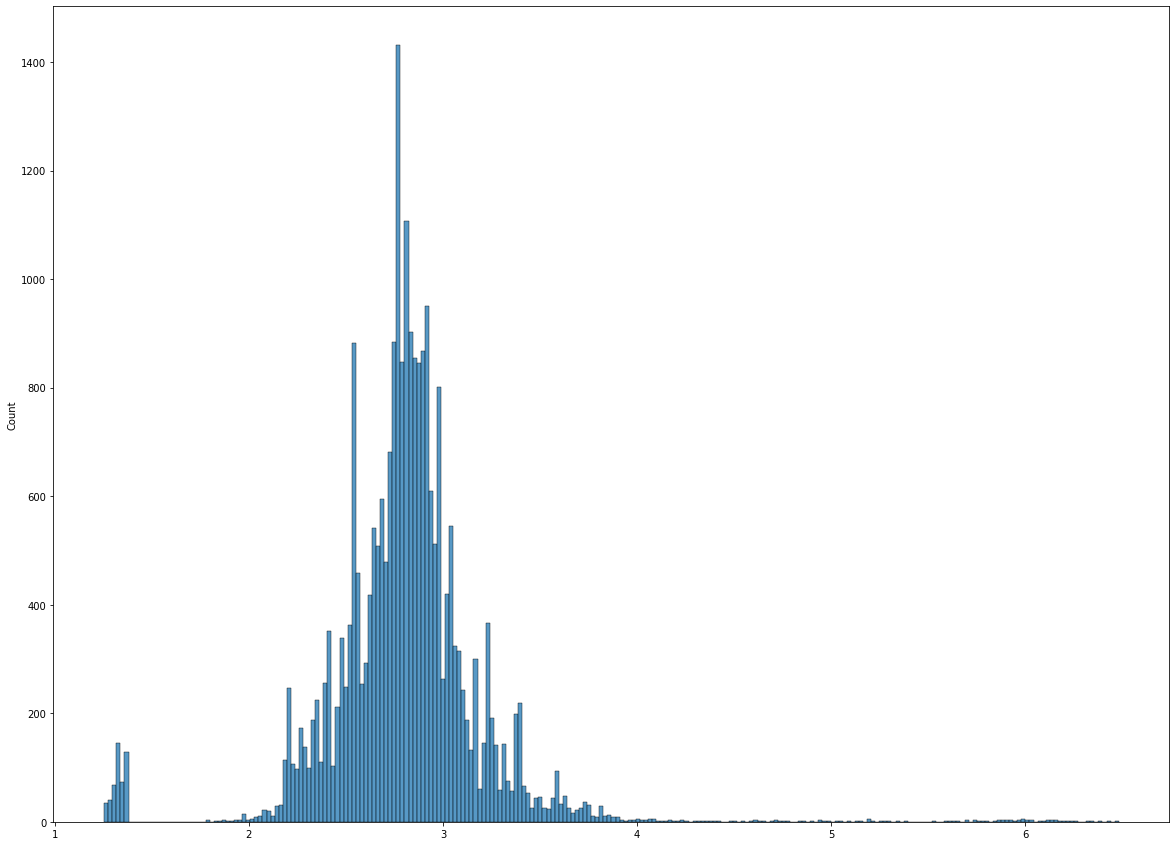

In [ ]:
# Here, we will plot sequence length distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
sns.histplot(data = np.log10(seq_lengths), bins = 250)
plt.show()

In [ ]:
def getKmers(sequence, size):
  return [sequence[x:x+size] for x in range(len(sequence) - size + 1)]


    ############################################################################
    # TASK 2: write the body of the function that extracts all k-mers of a 
    # given length (size) from a sequence. E.g. for a sequence SEQUENCE and 
    # size 3: {SEQ, EQU, QUE, UEN, ENC, NCE}.
    ############################################################################

# Given a sequence, get all possible k-mers of length l along it.
its = []
non_its = []
for i in its_seq:
  its.extend(getKmers(i, k_mer_size))
  
for i in non_its_seq:
  non_its.extend(getKmers(i, k_mer_size))

In [ ]:
print("Length of ITS:", len(its))
print("Length of non-ITS:", len(non_its))

Length of ITS: 2958627
Length of non-ITS: 8485695


In [ ]:
# Randomly pick up a subset of sequences 
import math
its = random.sample(its, math.floor(len(its) * frac_to_take))
non_its = random.sample(non_its, math.floor(len(non_its) * frac_to_take))
print("Length of ITS:", len(its))
print("Length of non-ITS:", len(non_its))
print("First 2 k-mers in a class:")
print("ITS: ", its[0:2])
print("non-ITS: ", non_its[0:2])

Length of ITS: 29586
Length of non-ITS: 84856
First 2 k-mers in a class:
ITS:  [Seq('TATTGAGTGATACTCTGTTAAACTGGGTTAACTTGAAATAGTGTGGCAAGAGCT...ACA'), Seq('TCTCGGCAACGGATATCTAGGCTCTCGCATCGATGAAAAACGTAGCGAAATGCG...GTG')]
non-ITS:  [Seq('CAGGCATACGCGAATCTTCGATTCGCTAGCTTAGCGAGTTTTCTTAATTTCTGT...TGT'), Seq('TCATCCTCACAATGGCTCTAAAATTGGAAGTCTTGACCCTAAAAGTTTAAAGGA...GTG')]


In [ ]:
# Encode bases in our k-mers so that each of the 4 channels corresponds to 
# the probability of each of the four bases.

def encodeSeq(seq):
  dict = {'A':[1,0,0,0],
            'T':[0,1,0,0],
            'C':[0,0,1,0],
            'G':[0,0,0,1],
            'R':[.5,0,0,.5],	         # A or G
            'Y':[0,.5,.5,0],	         # C or T
            'S':[0,0,.5,.5],        	 # G or C
            'W':[.5,.5,0,0],           # A or T
            'K':[0,.5,0,.5],       	   # G or T
            'M':[.5,0,.5,0],	         # A or C
            'B':[0,.33,.33,.33],	     # C or G or T
            'D':[.33,.33,0,.33],	     # A or G or T
            'H':[.33,.33,.33,0],	     # A or C or T
            'V':[.33,0,.33,.33],	     # A or C or G
            'N':[.25,.25,.25,.25]      # A or T or C or G
          }
  seq = list(seq.upper())
  encoded = [dict[base] for base in seq]
  return encoded

################################################################################
# TASK 3: create lists of encoded both its and the non-its sequences  
# using the provided encodeSeq function. 
################################################################################

encoded_its = []
encoded_non_its = []

for i in its:
  encoded_its.append(encodeSeq(i))
for i in non_its:
  encoded_non_its.append(encodeSeq(i))


In [ ]:
print("First 2 encoded k-mers in a class:")
print("Lenghts of encoded ITS: ", len(encoded_its),  ", non-its: ", len(encoded_non_its))
print(encoded_its[0:2])
#print(encoded_its2[0:2])
print(encoded_non_its[0:2])

First 2 encoded k-mers in a class:
Lenghts of encoded ITS:  29586 , non-its:  84856
[[[0, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 

In [ ]:
# Here, we will one-hot encode labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labels = list(np.ones(len(encoded_its))) + list(np.zeros(len(encoded_non_its)))

# One-hot encode Sequences
#integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder()  
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print('Labels:\n', labels.T) 
print('One-hot encoded labels:\n', input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [ ]:
# Prepare the training set
input_features = np.array(encoded_its + encoded_non_its)

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels, test_size = 0.25, random_state = 42)
print(train_features[0])
print(train_features.shape)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0.

In [ ]:
#from tkinter.ttk import _Padding
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2, l1

tf.compat.v1.disable_eager_execution()

model = Sequential()

model.add(Conv1D(128, 20, activation='relu', input_shape=(k_mer_size, 4)))
model.add(BatchNormalization())
model.add(Conv1D(128, 20, activation='relu', padding = 'same', kernel_regularizer='l2'),)
model.add(BatchNormalization())
model.add(Conv1D(128, 20, activation='relu', padding = 'same', kernel_regularizer='l2'),)
model.add(BatchNormalization())
model.add(Conv1D(128, 20, activation='relu', padding = 'same', kernel_regularizer='l2'),)
model.add(BatchNormalization())
model.add(Conv1D(128, 20, activation='relu', padding = 'same', kernel_regularizer='l2'),)
model.add(MaxPooling1D(2),)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

################################################################################
# TASK 4: define a sequential model with the following layers 
# (use l2 regularizer when possible):
# - convolutional 1D input layer (64 filters, kernel size 20, padding set to 'same' and 'relu' activation)
# - convolutional 1D with less filters and smaller kernel 
# - max pooling layer with pool size of 2
# - flatten layer
# - two dense layers where the lats one has a softmax activation
################################################################################

epochs = 20
lrate = 0.001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['categorical_accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_38 (Conv1D)          (None, 131, 128)          10368     
                                                                 
 batch_normalization_4 (Batc  (None, 131, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_39 (Conv1D)          (None, 131, 128)          327808    
                                                                 
 batch_normalization_5 (Batc  (None, 131, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_40 (Conv1D)          (None, 131, 128)          327808    
                                                                 
 batch_normalization_6 (Batc  (None, 131, 128)       

In [ ]:
# Training phase
hp_epochs = epochs
hp_batch_size = 32
hp_val_split = 0.2

cnn_model = model.fit(x = train_features, 
                      y = train_labels,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split
                      )

Train on 68664 samples, validate on 17167 samples
Epoch 1/20
68664/68664 [==============================] - 32s 459us/sample - loss: 3.6578 - categorical_accuracy: 0.9428 - val_loss: 2.3967 - val_categorical_accuracy: 0.9669
Epoch 2/20
68664/68664 [==============================] - 31s 455us/sample - loss: 1.7021 - categorical_accuracy: 0.9753 - val_loss: 1.2293 - val_categorical_accuracy: 0.9638
Epoch 3/20
68664/68664 [==============================] - 31s 450us/sample - loss: 0.8805 - categorical_accuracy: 0.9826 - val_loss: 0.6872 - val_categorical_accuracy: 0.9711
Epoch 4/20
68664/68664 [==============================] - 31s 452us/sample - loss: 0.5064 - categorical_accuracy: 0.9853 - val_loss: 0.4329 - val_categorical_accuracy: 0.9743
Epoch 5/20
68664/68664 [==============================] - 31s 452us/sample - loss: 0.3237 - categorical_accuracy: 0.9856 - val_loss: 0.3023 - val_categorical_accuracy: 0.9763
Epoch 6/20
68664/68664 [==============================] - 31s 452us/sample 

 1. With a smaller network (8,4) we get lower accuracy : loss: 0.2295 - categorical_accuracy: 0.9149 - val_loss: 0.2204 - val_categorical_accuracy: 0.9193


2. K size = 100 gives : loss: 0.1244 - categorical_accuracy: 0.9539 -   val_loss: 0.1674 - val_categorical_accuracy: 0.9367

  K = 50 gives : loss: 0.1840 - categorical_accuracy: 0.9313 - val_loss: 0.2325 - val_categorical_accuracy: 0.9104

  K = 150 gives : loss: 0.0728 - categorical_accuracy: 0.9728 - val_loss: 0.1113 - val_categorical_accuracy: 0.9587

  as we can se higer kmere size is better for accuracy 

Bonus:

1. loss: 0.0518 - categorical_accuracy: 0.9964 - val_loss: 0.1128 - val_categorical_accuracy: 0.9833 

with a more complex network:

conv1d_38 (Conv1D)          (None, 131, 128)          10368     
                                                                 
 batch_normalization_4 (Batc  (None, 131, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_39 (Conv1D)          (None, 131, 128)          327808    
                                                                 
 batch_normalization_5 (Batc  (None, 131, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_40 (Conv1D)          (None, 131, 128)          327808    
                                                                 
 batch_normalization_6 (Batc  (None, 131, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_41 (Conv1D)          (None, 131, 128)          327808    
                                                                 
 batch_normalization_7 (Batc  (None, 131, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_42 (Conv1D)          (None, 131, 128)          327808    
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 65, 128)          0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 8320)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                532544    
                                                                 
 dense_17 (Dense)            (None, 2)                 130 

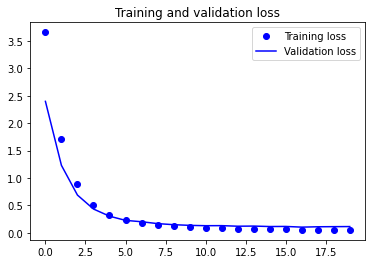

In [ ]:
# Below we will plot loss across consecutive timepoints throughout the training

#model.save_weights('its_cnn_weights.h5', overwrite = True)
from google.colab import drive
import keras

#drive.mount('/content/drive')
#model.save('/content/drive/its_cnn_model.h5')
#model = keras.models.load_model('its_cnn_model.h5')
loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Confusion matrix:
 [[21013   219]
 [  220  7159]]


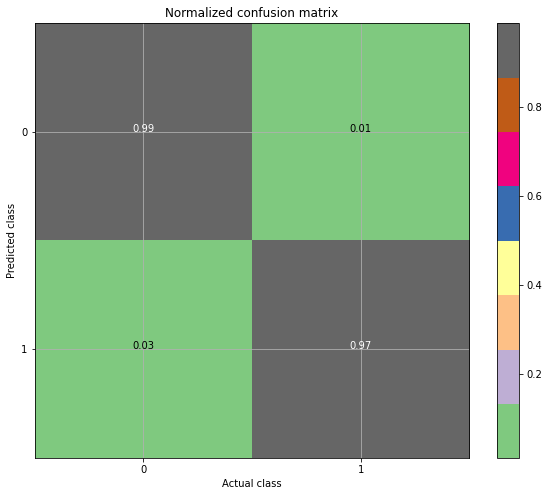

In [ ]:
# Below is the code to plot a confusion matrix as a heatmap.
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Accent)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('Actual class')
plt.ylabel('Predicted class')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()


In [ ]:
# Now, we evaluate our model on test data
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 98.47%


In [ ]:
# Code below will yield a saliency map for classifying the first 10 sequences.

import keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


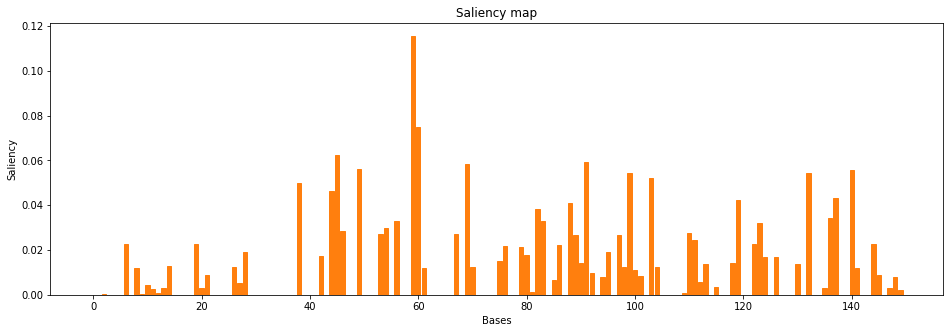

In [ ]:
K.set_learning_phase(1) #set learning phase
sals = []
for sequence_index in range(0,10):
  sals.append(compute_salient_bases(model, input_features[sequence_index]))

sal = sals[0]
#print(sals)

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(0,len(sal))]
plt.xlabel('Bases')
plt.ylabel('Saliency')
plt.title('Saliency map');
plt.show()

3. The edges are less importan not looking at length 1 or bigger then 150. It looks like it is taking batches primarily 60 

# Questions

Besides the code completion tasks defined in the comments above, there are a couple of additional questions/tasks:

1. Try to alter filter and kernel size in the first layers to some small values. Examine and briefly discuss how this affects prediction accuracy. 

2. Does the k-mer size have an effect on model's performance. Try 3 or more different k-mer sizes to try to answer this question. 

3. What do you think of the saliency map we generated, are there any immediate patterns emerging? Do you think such map advances our understanding of the mechanics of the model?

BONUS (1p)

1. Can you think of any different/better CNN architecture for this classification task? If so, try to implement and test it. Does it perform better or worse than the network in the lab?

2. Try making k-mers more noisy (randomly add Ns or other ambiguous symbols). How dos this affect the training performance with one-hot encoding vs. probabilities of 4 bases encoding? 